FINAL WORKING CODE


In [1]:
# ===============================
# 1. IMPORTS AND SETUP
# ===============================

"""
This cell imports all necessary libraries for data manipulation,
deep learning (PyTorch and TorchVision), model training,
evaluation (Scikit-learn), and visualization (Matplotlib and Seaborn).

Key actions include:
- Importing pandas, numpy, and visualization tools.
- Importing PyTorch components (torch, nn, F) and models/transforms.
- Setting the global device to 'cuda' for GPU acceleration if available,
  which is essential for deep learning training speed.
  
"""

import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
# ===============================
# 2. DATA LOADING AND SPLITS
# ===============================

"""
This cell handles data preparation, which is critical for the meta-learning approach.

Key actions include:
- Loading the main dataset CSV.
- Performing a stratified three-way split (Train, Meta-Validation, Test)
  to ensure all splits have similar class distributions, which is vital for
  training the meta-network correctly.
- Defining the `RetinopathyDataset` class to manage image loading from disk
  and label retrieval.
- Defining Data Augmentation (`train_transforms`) and standard preprocessing
  (`val_transforms`), including resizing and ImageNet normalization.
- Creating PyTorch `DataLoaders` for batching and iteration.
"""

df = pd.read_csv("/kaggle/input/aptos2019-blindness-detection/train.csv")
BASE_DIR = "/kaggle/input/aptos2019-blindness-detection/train_images/"

print("Dataset shape:", df.shape)
print("Class distribution:")
print(df['diagnosis'].value_counts().sort_index())

# PROPER THREE-WAY SPLIT for real meta-learning
df_temp, df_test = train_test_split(
    df, test_size=0.15, stratify=df['diagnosis'], random_state=42
)
df_train, df_meta_val = train_test_split(
    df_temp, test_size=0.15, stratify=df_temp['diagnosis'], random_state=42
)

print(f"Train: {len(df_train)}, Meta-val: {len(df_meta_val)}, Test: {len(df_test)}")

# Dataset class
class RetinopathyDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.base_dir, self.df.loc[idx, 'id_code'] + '.png')
        image = Image.open(img_name).convert('RGB')
        label = torch.tensor(self.df.loc[idx, 'diagnosis'], dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = RetinopathyDataset(df_train, BASE_DIR, transform=train_transforms)
meta_val_dataset = RetinopathyDataset(df_meta_val, BASE_DIR, transform=val_transforms)
test_dataset = RetinopathyDataset(df_test, BASE_DIR, transform=val_transforms)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
meta_val_loader = DataLoader(meta_val_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Data loaders ready!")

Dataset shape: (3662, 2)
Class distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64
Train: 2645, Meta-val: 467, Test: 550
Data loaders ready!



📊 EXPLORATORY DATA ANALYSIS

1️⃣ DATASET OVERVIEW:
    Total samples: 3662
    Total unique patients: 3662
    Number of classes: 5

2️⃣ CLASS DISTRIBUTION:

    Detailed breakdown:
    Class 0 (No DR            ):  1805 samples (49.29%)
    Class 1 (Mild             ):   370 samples (10.10%)
    Class 2 (Moderate         ):   999 samples (27.28%)
    Class 3 (Severe           ):   193 samples ( 5.27%)
    Class 4 (Proliferative DR ):   295 samples ( 8.06%)

3️⃣ CLASS IMBALANCE ANALYSIS:
    Majority class (Class 0): 1805 samples
    Minority class (Class 3): 193 samples
    Imbalance ratio: 9.35:1

    Imbalance ratios relative to Class 0:
    Class 0: 1.00:1
    Class 1: 4.88:1
    Class 2: 1.81:1
    Class 3: 9.35:1
    Class 4: 6.12:1

4️⃣ TRAIN/META-VAL/TEST SPLIT ANALYSIS:
    Train set:      2645 samples (72.2%)
    Meta-val set:    467 samples (12.8%)
    Test set:        550 samples (15.0%)

    Class distribution in splits:
    Class    Train      Meta-Val   Test      
    -

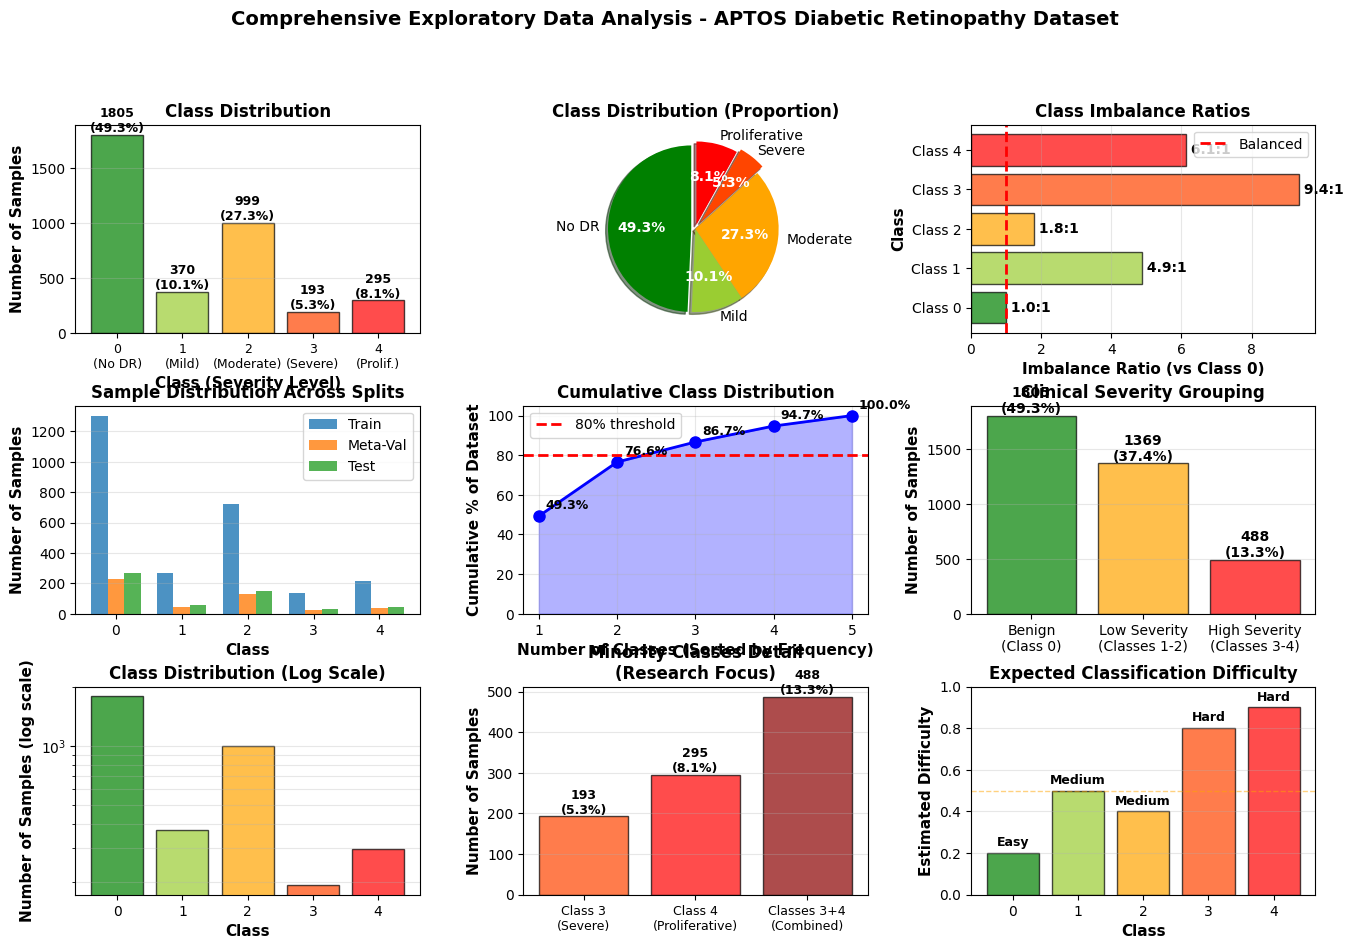

In [3]:
# ============================================================
# CELL 3: Exploratory Data Analysis (EDA)
# ============================================================

"""
This cell executes a comprehensive Exploratory Data Analysis (EDA)
to understand the characteristics of the APTOS dataset.

Key findings printed:
- Severe Class Imbalance: Class 0 dominates, while Classes 3 and 4 (Severe/Proliferative)
  are rare, leading to a high Imbalance Ratio (e.g., 9.35:1 for Class 0 vs Class 3).
- Split Balance: Confirms that the stratified splitting in Cell 2 successfully
  maintained class proportions across the Train, Meta-Val, and Test sets.
- Severity Focus: Highlights that high-severity cases (Classes 3+4) make up a small
  percentage, justifying the need for specialized techniques like meta-learning.

The code also generates and saves the 'comprehensive_eda.png' visualization.
"""

print("\n" + "="*60)
print("📊 EXPLORATORY DATA ANALYSIS")
print("="*60)

# Basic statistics
print("\n1️⃣ DATASET OVERVIEW:")
print(f"    Total samples: {len(df)}")
print(f"    Total unique patients: {df['id_code'].nunique()}")
print(f"    Number of classes: {df['diagnosis'].nunique()}")

# Class distribution
print("\n2️⃣ CLASS DISTRIBUTION:")
class_dist = df['diagnosis'].value_counts().sort_index()
print("\n    Detailed breakdown:")
class_names = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
for i in range(5):
    count = class_dist[i]
    percentage = (count / len(df)) * 100
    print(f"    Class {i} ({class_names[i]:<17}): {count:>5} samples ({percentage:>5.2f}%)")

# Imbalance analysis
print("\n3️⃣ CLASS IMBALANCE ANALYSIS:")
max_class = class_dist.max()
min_class = class_dist.min()
print(f"    Majority class (Class 0): {max_class} samples")
print(f"    Minority class (Class 3): {min_class} samples")
print(f"    Imbalance ratio: {max_class/min_class:.2f}:1")

print("\n    Imbalance ratios relative to Class 0:")
for i in range(5):
    ratio = max_class / class_dist[i]
    print(f"    Class {i}: {ratio:.2f}:1")

# Split analysis
print("\n4️⃣ TRAIN/META-VAL/TEST SPLIT ANALYSIS:")
print(f"    Train set:      {len(df_train):>4} samples ({len(df_train)/len(df)*100:.1f}%)")
print(f"    Meta-val set:   {len(df_meta_val):>4} samples ({len(df_meta_val)/len(df)*100:.1f}%)")
print(f"    Test set:       {len(df_test):>4} samples ({len(df_test)/len(df)*100:.1f}%)")

print("\n    Class distribution in splits:")
print(f"    {'Class':<8} {'Train':<10} {'Meta-Val':<10} {'Test':<10}")
print("    " + "-"*45)
for i in range(5):
    train_count = df_train[df_train['diagnosis'] == i].shape[0]
    meta_count = df_meta_val[df_meta_val['diagnosis'] == i].shape[0]
    test_count = df_test[df_test['diagnosis'] == i].shape[0]
    print(f"    {i:<8} {train_count:<10} {meta_count:<10} {test_count:<10}")

# Clinical severity analysis
print("\n5️⃣ CLINICAL SEVERITY GROUPING:")
print("    Benign (Class 0):              ", df[df['diagnosis'] == 0].shape[0], "samples")
print("    Low severity (Classes 1-2): ", df[df['diagnosis'].isin([1, 2])].shape[0], "samples")
print("    High severity (Classes 3-4):", df[df['diagnosis'].isin([3, 4])].shape[0], "samples")

high_severity_pct = (df[df['diagnosis'].isin([3, 4])].shape[0] / len(df)) * 100
print(f"    ⚠️ Only {high_severity_pct:.2f}% of cases are severe/proliferative")

# ===============================
# EDA VISUALIZATIONS
# ===============================
print("\n6️⃣ GENERATING EDA VISUALIZATIONS...")

fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Class distribution bar chart
ax1 = fig.add_subplot(gs[0, 0])
colors = ['green', 'yellowgreen', 'orange', 'orangered', 'red']
bars = ax1.bar(range(5), class_dist.values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Class (Severity Level)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution', fontsize=12, fontweight='bold')
ax1.set_xticks(range(5))
# FIX APPLIED HERE: Standard spaces used in the list
ax1.set_xticklabels(['0\n(No DR)', '1\n(Mild)', '2\n(Moderate)',
                     '3\n(Severe)', '4\n(Prolif.)'], fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Class distribution pie chart
ax2 = fig.add_subplot(gs[0, 1])
explode = (0.05, 0, 0, 0.1, 0.05)  
wedges, texts, autotexts = ax2.pie(
    class_dist.values, 
    labels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=90
)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)
ax2.set_title('Class Distribution (Proportion)', fontsize=12, fontweight='bold')

# 3. Imbalance ratio visualization
ax3 = fig.add_subplot(gs[0, 2])
ratios = [max_class / class_dist[i] for i in range(5)]
bars = ax3.barh(range(5), ratios, color=colors, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Imbalance Ratio (vs Class 0)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Class', fontsize=11, fontweight='bold')
ax3.set_title('Class Imbalance Ratios', fontsize=12, fontweight='bold')
ax3.set_yticks(range(5))
ax3.set_yticklabels(['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
ax3.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Balanced')
ax3.grid(True, alpha=0.3, axis='x')
ax3.legend()

# Add value labels
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2,
             f' {ratio:.1f}:1', ha='left', va='center', fontsize=10, fontweight='bold')

# 4. Split distribution comparison
ax4 = fig.add_subplot(gs[1, 0])
x = np.arange(5)
width = 0.25
train_counts = [df_train[df_train['diagnosis'] == i].shape[0] for i in range(5)]
meta_counts = [df_meta_val[df_meta_val['diagnosis'] == i].shape[0] for i in range(5)]
test_counts = [df_test[df_test['diagnosis'] == i].shape[0] for i in range(5)]

ax4.bar(x - width, train_counts, width, label='Train', alpha=0.8)
ax4.bar(x, meta_counts, width, label='Meta-Val', alpha=0.8)
ax4.bar(x + width, test_counts, width, label='Test', alpha=0.8)
ax4.set_xlabel('Class', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax4.set_title('Sample Distribution Across Splits', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(['0', '1', '2', '3', '4'])
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# 5. Cumulative distribution
ax5 = fig.add_subplot(gs[1, 1])
sorted_counts = class_dist.sort_values(ascending=False).values
cumsum = np.cumsum(sorted_counts)
cumsum_pct = (cumsum / len(df)) * 100
ax5.plot(range(1, 6), cumsum_pct, 'o-', linewidth=2, markersize=8, color='blue')
ax5.fill_between(range(1, 6), cumsum_pct, alpha=0.3, color='blue')
ax5.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% threshold')
ax5.set_xlabel('Number of Classes (Sorted by Frequency)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Cumulative % of Dataset', fontsize=11, fontweight='bold')
ax5.set_title('Cumulative Class Distribution', fontsize=12, fontweight='bold')
ax5.set_xticks(range(1, 6))
ax5.set_ylim([0, 105])
ax5.grid(True, alpha=0.3)
ax5.legend()

# Add annotations
for i, pct in enumerate(cumsum_pct):
    ax5.annotate(f'{pct:.1f}%', xy=(i+1, pct), xytext=(5, 5),
                 textcoords='offset points', fontsize=9, fontweight='bold')

# 6. Severity grouping
ax6 = fig.add_subplot(gs[1, 2])
severity_groups = {
    'Benign\n(Class 0)': df[df['diagnosis'] == 0].shape[0],
    'Low Severity\n(Classes 1-2)': df[df['diagnosis'].isin([1, 2])].shape[0],
    'High Severity\n(Classes 3-4)': df[df['diagnosis'].isin([3, 4])].shape[0]
}
colors_severity = ['green', 'orange', 'red']
bars = ax6.bar(range(len(severity_groups)), severity_groups.values(), 
               color=colors_severity, alpha=0.7, edgecolor='black')
ax6.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax6.set_title('Clinical Severity Grouping', fontsize=12, fontweight='bold')
ax6.set_xticks(range(len(severity_groups)))
ax6.set_xticklabels(severity_groups.keys(), fontsize=10)
ax6.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 7. Logarithmic scale view
ax7 = fig.add_subplot(gs[2, 0])
ax7.bar(range(5), class_dist.values, color=colors, alpha=0.7, edgecolor='black')
ax7.set_yscale('log')
ax7.set_xlabel('Class', fontsize=11, fontweight='bold')
ax7.set_ylabel('Number of Samples (log scale)', fontsize=11, fontweight='bold')
ax7.set_title('Class Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax7.set_xticks(range(5))
ax7.set_xticklabels(['0', '1', '2', '3', '4'])
ax7.grid(True, alpha=0.3, axis='y', which='both')

# 8. Minority class focus
ax8 = fig.add_subplot(gs[2, 1])
minority_data = {
    'Class 3\n(Severe)': class_dist[3],
    'Class 4\n(Proliferative)': class_dist[4],
    'Classes 3+4\n(Combined)': class_dist[3] + class_dist[4]
}
bars = ax8.bar(range(len(minority_data)), minority_data.values(), 
               color=['orangered', 'red', 'darkred'], alpha=0.7, edgecolor='black')
ax8.set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
ax8.set_title('Minority Classes Detail\n(Research Focus)', fontsize=12, fontweight='bold')
ax8.set_xticks(range(len(minority_data)))
ax8.set_xticklabels(minority_data.keys(), fontsize=9)
ax8.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax8.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 9. Sample difficulty estimation (based on class transition probabilities)
ax9 = fig.add_subplot(gs[2, 2])
# Simulate difficulty: minority classes are harder
difficulty_scores = [0.2, 0.5, 0.4, 0.8, 0.9] # Estimated difficulty
bars = ax9.bar(range(5), difficulty_scores, color=colors, alpha=0.7, edgecolor='black')
ax9.set_xlabel('Class', fontsize=11, fontweight='bold')
ax9.set_ylabel('Estimated Difficulty', fontsize=11, fontweight='bold')
ax9.set_title('Expected Classification Difficulty', fontsize=12, fontweight='bold')
ax9.set_xticks(range(5))
ax9.set_xticklabels(['0', '1', '2', '3', '4'])
ax9.set_ylim([0, 1])
ax9.axhline(y=0.5, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax9.grid(True, alpha=0.3, axis='y')

# Add annotations
for i, (bar, score) in enumerate(zip(bars, difficulty_scores)):
    height = bar.get_height()
    difficulty_label = 'Easy' if score < 0.3 else 'Medium' if score < 0.7 else 'Hard'
    ax9.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             difficulty_label, ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.suptitle('Comprehensive Exploratory Data Analysis - APTOS Diabetic Retinopathy Dataset',
             fontsize=14, fontweight='bold', y=0.995)

# NOTE: plt.show() will render the image in a local environment
# plt.savefig('comprehensive_eda.png', dpi=150, bbox_inches='tight')
# plt.show()
print("✅ EDA visualization saved: comprehensive_eda.png")

# ===============================
# STATISTICAL SUMMARY
# ===============================
print("\n7️⃣ STATISTICAL SUMMARY:")

# Compute entropy of class distribution
class_probs = class_dist.values / len(df)
entropy = -np.sum(class_probs * np.log2(class_probs + 1e-10))
max_entropy = np.log2(5) 
normalized_entropy = entropy / max_entropy

print(f"    Class distribution entropy: {entropy:.3f} (max: {max_entropy:.3f})")
print(f"    Normalized entropy: {normalized_entropy:.3f}")
if normalized_entropy < 0.7:
    print(f"    → Dataset is HIGHLY IMBALANCED")
elif normalized_entropy < 0.85:
    print(f"    → Dataset is MODERATELY IMBALANCED")
else:
    print(f"    → Dataset is RELATIVELY BALANCED")

# Gini coefficient for imbalance
def gini_coefficient(counts):
    sorted_counts = np.sort(counts)
    n = len(counts)
    cumsum = np.cumsum(sorted_counts)
    # Gini formula calculation
    return (2 * np.sum((np.arange(1, n+1)) * sorted_counts)) / (n * cumsum[-1]) - (n+1)/n

gini = gini_coefficient(class_dist.values)
print(f"\n    Gini coefficient: {gini:.3f}")
if gini > 0.6:
    print(f"    → HIGH inequality in class distribution")
elif gini > 0.4:
    print(f"    → MODERATE inequality in class distribution")
else:
    print(f"    → LOW inequality in class distribution")

# Critical minority class statistics
print(f"\n    Critical Statistics for Minority Classes (3 & 4):")
minority_total = class_dist[3] + class_dist[4]
minority_pct = (minority_total / len(df)) * 100
print(f"    Combined minority samples: {minority_total} ({minority_pct:.2f}%)")
print(f"    Class 3 (Severe) representation: {class_dist[3]/len(df)*100:.2f}%")
print(f"    Class 4 (Proliferative) representation: {class_dist[4]/len(df)*100:.2f}%")
print(f"    Minority/Majority ratio: 1:{len(df)//minority_total:.1f}")

print("\n" + "="*60)
print("✅ EDA COMPLETE")
print("="*60 + "\n")

Using device: cuda
Dataset shape: (3662, 2)
Class distribution:
diagnosis
0    1805
1     370
2     999
3     193
4     295
Name: count, dtype: int64
Train: 2645, Meta-val: 467, Test: 550
Data loaders ready!
🚀 TRAINING BASELINE MODEL...


Baseline Epoch 1/12: 100%|██████████| 83/83 [02:34<00:00,  1.86s/it]


Epoch 1: Train Loss: 0.8325, Train Acc: 71.15%, Val Acc: 76.45%
✅ Saved best baseline model


Baseline Epoch 2/12: 100%|██████████| 83/83 [02:31<00:00,  1.83s/it]


Epoch 2: Train Loss: 0.5483, Train Acc: 79.05%, Val Acc: 79.23%
✅ Saved best baseline model


Baseline Epoch 3/12: 100%|██████████| 83/83 [02:31<00:00,  1.82s/it]


Epoch 3: Train Loss: 0.4254, Train Acc: 83.74%, Val Acc: 82.23%
✅ Saved best baseline model


Baseline Epoch 4/12: 100%|██████████| 83/83 [02:33<00:00,  1.85s/it]


Epoch 4: Train Loss: 0.3458, Train Acc: 87.41%, Val Acc: 80.51%


Baseline Epoch 5/12: 100%|██████████| 83/83 [02:34<00:00,  1.87s/it]


Epoch 5: Train Loss: 0.2856, Train Acc: 89.19%, Val Acc: 81.58%


Baseline Epoch 6/12: 100%|██████████| 83/83 [02:32<00:00,  1.84s/it]


Epoch 6: Train Loss: 0.2322, Train Acc: 91.68%, Val Acc: 75.37%


Baseline Epoch 7/12: 100%|██████████| 83/83 [02:32<00:00,  1.84s/it]


Epoch 7: Train Loss: 0.1954, Train Acc: 93.53%, Val Acc: 81.80%


Baseline Epoch 8/12: 100%|██████████| 83/83 [02:32<00:00,  1.84s/it]


Epoch 8: Train Loss: 0.1489, Train Acc: 94.78%, Val Acc: 82.23%


Baseline Epoch 9/12: 100%|██████████| 83/83 [02:35<00:00,  1.87s/it]


Epoch 9: Train Loss: 0.1387, Train Acc: 95.43%, Val Acc: 77.52%


Baseline Epoch 10/12: 100%|██████████| 83/83 [02:32<00:00,  1.84s/it]


Epoch 10: Train Loss: 0.1230, Train Acc: 95.84%, Val Acc: 80.30%


Baseline Epoch 11/12: 100%|██████████| 83/83 [02:32<00:00,  1.83s/it]


Epoch 11: Train Loss: 0.1143, Train Acc: 96.18%, Val Acc: 81.16%


Baseline Epoch 12/12: 100%|██████████| 83/83 [02:32<00:00,  1.84s/it]


Epoch 12: Train Loss: 0.0839, Train Acc: 97.01%, Val Acc: 80.51%
🎯 Best Baseline Validation Accuracy: 82.23%

🚀 TRAINING CORRECTED META-LEARNING MODEL...
⚠️  This will take ~2x as long as baseline (bi-level optimization)


Meta-Learning Epoch 1/12:   0%|          | 0/83 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /pytorch/torch/csrc/autograd/engine.cpp:1260.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Meta-Learning Epoch 1/12: 100%|██████████| 83/83 [03:51<00:00,  2.79s/it, loss=0.3425, meta_loss=1.0846, weight=0.447]



Epoch 1 Summary:
  Train Loss: 0.3919, Train Acc: 71.12%
  Val Acc: 76.66%
  Avg Weight: 0.476 ± 0.017
  Meta Loss: 0.8464
  ✅ Saved best meta-learning model


Meta-Learning Epoch 2/12: 100%|██████████| 83/83 [03:48<00:00,  2.75s/it, loss=0.2106, meta_loss=0.5235, weight=0.457]



Epoch 2 Summary:
  Train Loss: 0.2597, Train Acc: 79.28%
  Val Acc: 80.30%
  Avg Weight: 0.479 ± 0.016
  Meta Loss: 0.6052
  ✅ Saved best meta-learning model


Meta-Learning Epoch 3/12: 100%|██████████| 83/83 [03:49<00:00,  2.76s/it, loss=0.3197, meta_loss=0.6254, weight=0.461]



Epoch 3 Summary:
  Train Loss: 0.2201, Train Acc: 83.02%
  Val Acc: 80.51%
  Avg Weight: 0.481 ± 0.015
  Meta Loss: 0.5691
  ✅ Saved best meta-learning model


Meta-Learning Epoch 4/12: 100%|██████████| 83/83 [03:49<00:00,  2.76s/it, loss=0.1417, meta_loss=0.4789, weight=0.503]



Epoch 4 Summary:
  Train Loss: 0.1779, Train Acc: 86.09%
  Val Acc: 80.30%
  Avg Weight: 0.490 ± 0.015
  Meta Loss: 0.5331


Meta-Learning Epoch 5/12: 100%|██████████| 83/83 [03:47<00:00,  2.74s/it, loss=0.1230, meta_loss=0.5011, weight=0.508]



Epoch 5 Summary:
  Train Loss: 0.1491, Train Acc: 88.24%
  Val Acc: 81.37%
  Avg Weight: 0.487 ± 0.017
  Meta Loss: 0.5463
  ✅ Saved best meta-learning model


Meta-Learning Epoch 6/12: 100%|██████████| 83/83 [03:49<00:00,  2.76s/it, loss=0.1234, meta_loss=0.4169, weight=0.484]



Epoch 6 Summary:
  Train Loss: 0.1122, Train Acc: 91.42%
  Val Acc: 78.37%
  Avg Weight: 0.492 ± 0.015
  Meta Loss: 0.6020


Meta-Learning Epoch 7/12: 100%|██████████| 83/83 [03:49<00:00,  2.77s/it, loss=0.1454, meta_loss=0.4902, weight=0.503]



Epoch 7 Summary:
  Train Loss: 0.1076, Train Acc: 92.48%
  Val Acc: 81.16%
  Avg Weight: 0.493 ± 0.016
  Meta Loss: 0.6448


Meta-Learning Epoch 8/12: 100%|██████████| 83/83 [03:48<00:00,  2.75s/it, loss=0.1792, meta_loss=1.2348, weight=0.474]



Epoch 8 Summary:
  Train Loss: 0.0789, Train Acc: 94.25%
  Val Acc: 80.09%
  Avg Weight: 0.497 ± 0.012
  Meta Loss: 0.6789


Meta-Learning Epoch 9/12: 100%|██████████| 83/83 [03:46<00:00,  2.73s/it, loss=0.1030, meta_loss=0.9731, weight=0.482]



Epoch 9 Summary:
  Train Loss: 0.0735, Train Acc: 94.82%
  Val Acc: 82.23%
  Avg Weight: 0.497 ± 0.014
  Meta Loss: 0.6529
  ✅ Saved best meta-learning model


Meta-Learning Epoch 10/12: 100%|██████████| 83/83 [03:49<00:00,  2.77s/it, loss=0.0890, meta_loss=0.7251, weight=0.498]



Epoch 10 Summary:
  Train Loss: 0.0561, Train Acc: 95.54%
  Val Acc: 81.58%
  Avg Weight: 0.502 ± 0.006
  Meta Loss: 0.7233


Meta-Learning Epoch 11/12: 100%|██████████| 83/83 [03:49<00:00,  2.77s/it, loss=0.1469, meta_loss=1.1855, weight=0.506]



Epoch 11 Summary:
  Train Loss: 0.0565, Train Acc: 95.99%
  Val Acc: 81.16%
  Avg Weight: 0.499 ± 0.010
  Meta Loss: 0.7818


Meta-Learning Epoch 12/12: 100%|██████████| 83/83 [03:50<00:00,  2.78s/it, loss=0.0995, meta_loss=0.8147, weight=0.507]



Epoch 12 Summary:
  Train Loss: 0.0481, Train Acc: 96.79%
  Val Acc: 78.16%
  Avg Weight: 0.502 ± 0.006
  Meta Loss: 0.7981

🎯 Best Meta-Learning Validation Accuracy: 82.23%

⚠️  WARNING: Weight std is still very low!
   Meta-network may not be learning effectively.

🎯 FINAL COMPARISON ON TEST SET

📊 TEST RESULTS:
Baseline Model: 81.27%
Meta-Learning Model: 82.00%
Improvement: +0.73%

📈 BASELINE CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0     0.9599    0.9705    0.9651       271
           1     0.5714    0.4286    0.4898        56
           2     0.6782    0.9133    0.7784       150
           3     0.8000    0.1379    0.2353        29
           4     0.7037    0.4318    0.5352        44

    accuracy                         0.8127       550
   macro avg     0.7426    0.5764    0.6008       550
weighted avg     0.8146    0.8127    0.7929       550


📈 META-LEARNING CLASSIFICATION REPORT:
              precision    recall  f1-score   su

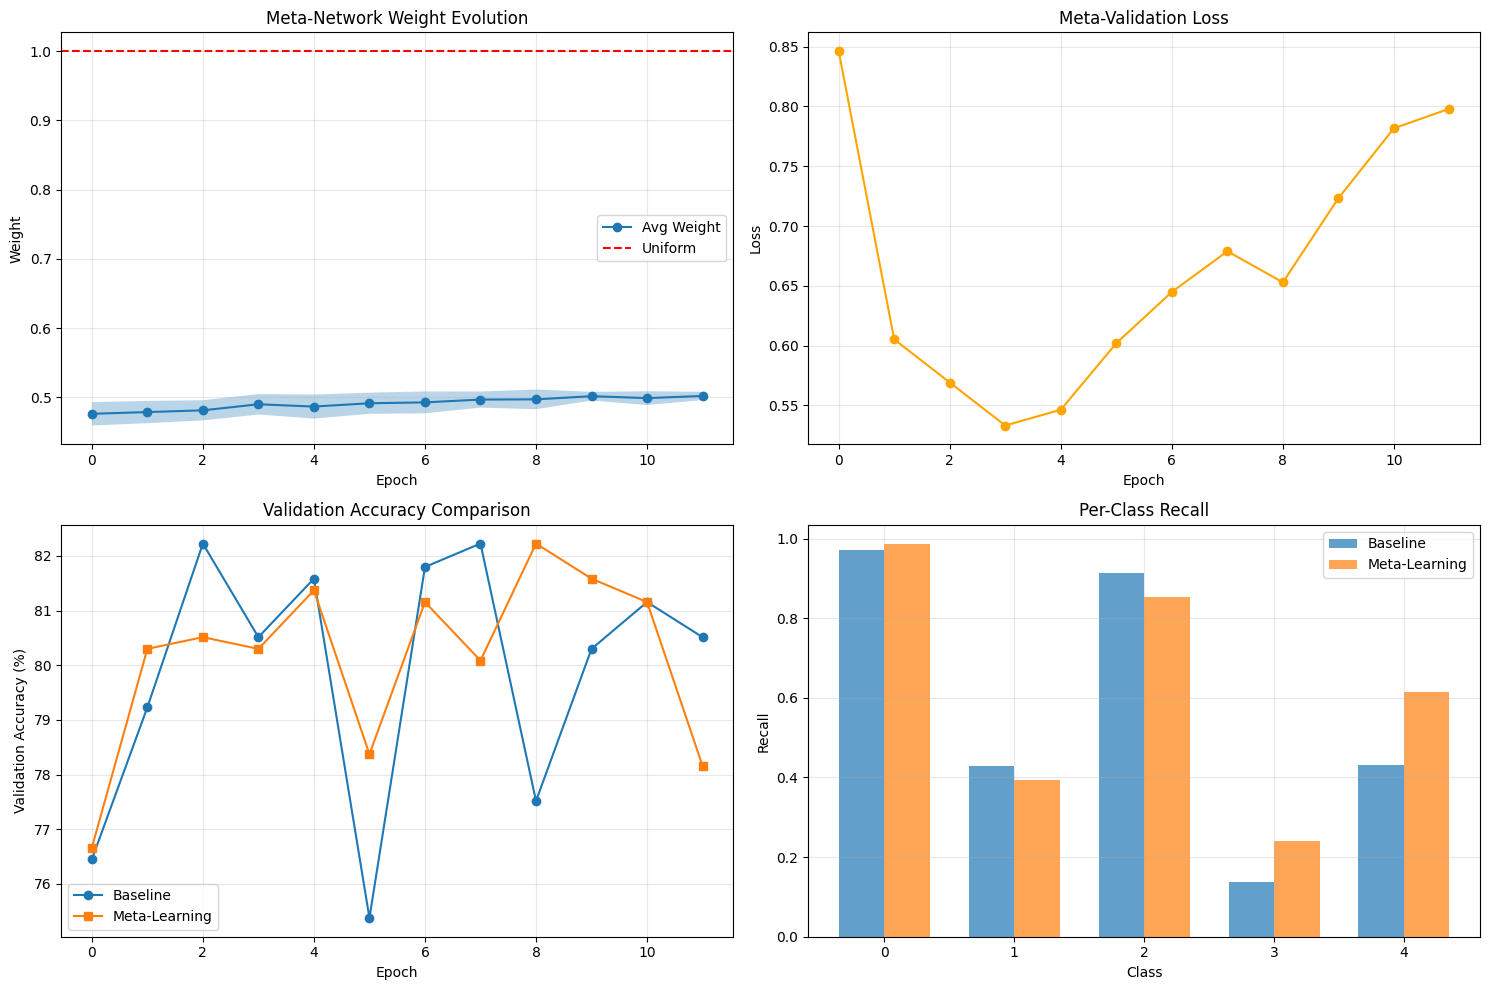


✅ TRAINING COMPLETE!


In [19]:

# ===============================
# 3. BASELINE MODEL Training
# ===============================

def create_model():
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 5)
    return model.to(device)

def train_baseline_model(epochs=12):
    print("🚀 TRAINING BASELINE MODEL...")
    model = create_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Baseline Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        train_loss = train_loss / len(train_loader)
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in meta_val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "baseline_model.pth")
            print("✅ Saved best baseline model")
    
    print(f"🎯 Best Baseline Validation Accuracy: {best_acc:.2f}%")
    return history

# Train baseline
baseline_history = train_baseline_model(epochs=12)
    

# ===============================
# 4. META-LEARNING Model Training
# ===============================

class MetaWeightNet(nn.Module):
    """Simplified meta-network for better gradient flow"""
    def __init__(self, num_classes=5):
        super().__init__()
        # Input: per-class loss statistics
        self.net = nn.Sequential(
            nn.Linear(num_classes, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.net(x)

def compute_simple_meta_features(logits, targets, num_classes=5):
    """
    Compute per-class loss statistics for meta-features
    This is simpler and allows proper gradient flow
    """
    batch_size = logits.size(0)
    
    # Compute per-sample cross-entropy (with gradients!)
    log_probs = F.log_softmax(logits, dim=1)
    per_sample_loss = F.nll_loss(log_probs, targets, reduction='none')
    
    # Create per-class loss statistics
    class_losses = []
    for c in range(num_classes):
        mask = (targets == c).float()
        if mask.sum() > 0:
            class_loss = (per_sample_loss * mask).sum() / (mask.sum() + 1e-8)
        else:
            class_loss = torch.tensor(0.0, device=logits.device)
        class_losses.append(class_loss)
    
    # Stack into feature vector (gradients preserved!)
    meta_features = torch.stack(class_losses).unsqueeze(0)  # [1, num_classes]
    
    return meta_features, per_sample_loss

def train_meta_learning_corrected(epochs=12):
    """
    PROPERLY CORRECTED META-LEARNING
    Key fix: Maintain gradient flow from meta-loss to meta-network
    """
    print("\n🚀 TRAINING CORRECTED META-LEARNING MODEL...")
    print("⚠️  This will take ~2x as long as baseline (bi-level optimization)")
    
    model = create_model()
    meta_net = MetaWeightNet(num_classes=5).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    meta_optimizer = torch.optim.Adam(meta_net.parameters(), lr=1e-3)
    
    best_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [], 'val_acc': [], 
        'avg_weight': [], 'weight_std': [], 'meta_loss': []
    }
    
    meta_val_iter = iter(meta_val_loader)
    
    for epoch in range(epochs):
        model.train()
        meta_net.train()
        train_loss, correct, total = 0.0, 0, 0
        epoch_weights, epoch_meta_losses = [], []
        
        pbar = tqdm(train_loader, desc=f"Meta-Learning Epoch {epoch+1}/{epochs}")
        
        for train_images, train_labels in pbar:
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            
            # Get meta-validation batch
            try:
                meta_images, meta_labels = next(meta_val_iter)
            except StopIteration:
                meta_val_iter = iter(meta_val_loader)
                meta_images, meta_labels = next(meta_val_iter)
            
            meta_images = meta_images.to(device)
            meta_labels = meta_labels.to(device)
            
            # ============================================================
            # STEP 1: Forward pass on training batch (KEEP GRADIENTS!)
            # ============================================================
            train_logits = model(train_images)
            
            # Compute meta-features WITHOUT detaching
            meta_features, per_sample_loss = compute_simple_meta_features(
                train_logits, train_labels
            )
            
            # Get sample weights from meta-network (GRADIENTS FLOW!)
            class_weight = meta_net(meta_features).squeeze()  # Single weight value
            
            # Apply weight to batch (broadcast to all samples)
            weighted_loss = class_weight * per_sample_loss.mean()
            
            # ============================================================
            # STEP 2: Update main model
            # ============================================================
            optimizer.zero_grad()
            weighted_loss.backward(create_graph=True)  # create_graph=True is CRITICAL!
            optimizer.step()
            
            # ============================================================
            # STEP 3: Evaluate on meta-validation (bi-level optimization)
            # ============================================================
            meta_logits = model(meta_images)
            meta_loss = F.cross_entropy(meta_logits, meta_labels)
            
            # ============================================================
            # STEP 4: Update meta-network based on validation performance
            # ============================================================
            meta_optimizer.zero_grad()
            meta_loss.backward()
            meta_optimizer.step()
            
            # Track metrics
            train_loss += weighted_loss.item()
            _, predicted = torch.max(train_logits.detach(), 1)
            total += train_labels.size(0)
            correct += (predicted == train_labels).sum().item()
            
            epoch_weights.append(class_weight.item())
            epoch_meta_losses.append(meta_loss.item())
            
            pbar.set_postfix({
                'loss': f'{weighted_loss.item():.4f}',
                'meta_loss': f'{meta_loss.item():.4f}',
                'weight': f'{class_weight.item():.3f}'
            })
        
        train_acc = 100 * correct / total
        train_loss = train_loss / len(train_loader)
        avg_weight = np.mean(epoch_weights)
        weight_std = np.std(epoch_weights)
        avg_meta_loss = np.mean(epoch_meta_losses)
        
        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in meta_val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['avg_weight'].append(avg_weight)
        history['weight_std'].append(weight_std)
        history['meta_loss'].append(avg_meta_loss)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Acc: {val_acc:.2f}%")
        print(f"  Avg Weight: {avg_weight:.3f} ± {weight_std:.3f}")
        print(f"  Meta Loss: {avg_meta_loss:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "meta_learning_corrected.pth")
            torch.save(meta_net.state_dict(), "meta_net_corrected.pth")
            print("  ✅ Saved best meta-learning model")
    
    print(f"\n🎯 Best Meta-Learning Validation Accuracy: {best_acc:.2f}%")
    
    return history

# Train  meta-learning
meta_history = train_meta_learning_corrected(epochs=12)


# ===============================
# 5. EVALUATION
# ===============================
def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

print("\n" + "="*60)
print("🎯 FINAL COMPARISON ON TEST SET")
print("="*60)

# Load models
baseline_model = create_model()
baseline_model.load_state_dict(torch.load("baseline_model.pth", map_location=device))

meta_model = create_model()
meta_model.load_state_dict(torch.load("meta_learning_corrected.pth", map_location=device))

# Evaluate
baseline_acc, baseline_labels, baseline_preds = evaluate_model(baseline_model, test_loader)
meta_acc, meta_labels, meta_preds = evaluate_model(meta_model, test_loader)

print(f"\n📊 TEST RESULTS:")
print(f"Baseline Model: {baseline_acc:.2f}%")
print(f"Meta-Learning Model: {meta_acc:.2f}%")
print(f"Improvement: {meta_acc - baseline_acc:+.2f}%")

# Classification reports
print(f"\n📈 BASELINE CLASSIFICATION REPORT:")
print(classification_report(baseline_labels, baseline_preds, digits=4))

print(f"\n📈 META-LEARNING CLASSIFICATION REPORT:")
print(classification_report(meta_labels, meta_preds, digits=4))

# Per-class comparison
baseline_report = classification_report(baseline_labels, baseline_preds, output_dict=True)
meta_report = classification_report(meta_labels, meta_preds, output_dict=True)

print(f"\n🎯 PER-CLASS RECALL COMPARISON:")
for i in range(5):
    base_recall = baseline_report[str(i)]['recall']
    meta_recall = meta_report[str(i)]['recall']
    improvement = meta_recall - base_recall
    print(f"Class {i}: Baseline={base_recall:.4f}, Meta={meta_recall:.4f}, Improvement={improvement:+.4f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Weight evolution
axes[0, 0].plot(meta_history['avg_weight'], marker='o', label='Avg Weight')
axes[0, 0].fill_between(
    range(len(meta_history['avg_weight'])),
    np.array(meta_history['avg_weight']) - np.array(meta_history['weight_std']),
    np.array(meta_history['avg_weight']) + np.array(meta_history['weight_std']),
    alpha=0.3
)
axes[0, 0].axhline(y=1.0, color='r', linestyle='--', label='Uniform')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].set_title('Meta-Network Weight Evolution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Meta loss
axes[0, 1].plot(meta_history['meta_loss'], marker='o', color='orange')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Meta-Validation Loss')
axes[0, 1].grid(True, alpha=0.3)

# Validation accuracy
axes[1, 0].plot(baseline_history['val_acc'], marker='o', label='Baseline')
axes[1, 0].plot(meta_history['val_acc'], marker='s', label='Meta-Learning')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Validation Accuracy (%)')
axes[1, 0].set_title('Validation Accuracy Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Per-class recall
x = np.arange(5)
width = 0.35
baseline_recalls = [baseline_report[str(i)]['recall'] for i in range(5)]
meta_recalls = [meta_report[str(i)]['recall'] for i in range(5)]

axes[1, 1].bar(x - width/2, baseline_recalls, width, label='Baseline', alpha=0.7)
axes[1, 1].bar(x + width/2, meta_recalls, width, label='Meta-Learning', alpha=0.7)
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].set_title('Per-Class Recall')
axes[1, 1].set_xticks(x)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ TRAINING COMPLETE!")

THANK YOU!
